# Imports

In [26]:
# Tobi

from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel

In [27]:
# Simon

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

# Data Analysis

In [28]:
mushrooms_train = pd.read_csv('data/train.csv')
mushrooms_test = pd.read_csv('data/test.csv')

## Value Counts
* Balanced classes
* All data categorical
* Some categories have only few members

In [29]:
for column in mushrooms_train.columns:
    print(column, '\n', mushrooms_train[column].value_counts().sort_values(ascending=False), '\n')

cap.shape 
 x    2935
f    2534
k     652
b     349
s      28
c       1
Name: cap.shape, dtype: int64 

cap.color 
 n    1823
g    1487
e    1197
y     848
w     823
b     143
p     117
c      34
u      14
r      13
Name: cap.color, dtype: int64 

bruises 
 False    3764
True     2735
Name: bruises, dtype: int64 

stalk.color.above.ring 
 w    3537
p    1536
g     452
n     358
b     346
o     156
e      78
c      29
y       7
Name: stalk.color.above.ring, dtype: int64 

stalk.color.below.ring 
 w    3481
p    1494
g     467
n     421
b     352
o     156
e      80
c      29
y      19
Name: stalk.color.below.ring, dtype: int64 

population 
 v    3219
y    1392
s     993
n     320
a     302
c     273
Name: population, dtype: int64 

Id 
 6573    1
1895    1
5789    1
6187    1
2508    1
       ..
6206    1
4658    1
5000    1
6381    1
373     1
Name: Id, Length: 6499, dtype: int64 

poisonous 
 0    3342
1    3157
Name: poisonous, dtype: int64 



## Missing Values
* No missing values

In [5]:
for column in mushrooms_test.columns:
    print(column, '\n', mushrooms_test[column].isna().sum(), '\n')

Id 
 0 

cap.shape 
 0 

cap.color 
 0 

stalk.color.above.ring 
 0 

stalk.color.below.ring 
 0 

bruises 
 0 

population 
 0 



# Preprocessor pipe

In [30]:
# Split in features and target
X = mushrooms_train.drop(['poisonous'], axis=1)
y = mushrooms_train['poisonous']

In [31]:
columns = mushrooms_train.columns[:-2]

cat_pipe = Pipeline(steps= [
    ('transformer', OneHotEncoder())
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_pipe', cat_pipe, columns),
    ], verbose= False
)

## Conduct Preprocessing

In [32]:
# Preprocess train data
X.drop('Id', axis=1, inplace = True)

# Split in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [33]:
# Preprocess final test data
X_test_final = mushrooms_test.drop(['Id'], axis=1)

# Functions

## Plot AUROC

In [34]:
def plotAUROC(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Get Confusion Matrix

In [38]:
def get_confusion_matrix(y, y_pred):
    confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_test),
                                    columns=['Predicted Not Poisonous', 'Predicted Poisonous'],
                                    index=['True Not Poisonous', 'True Poisonous']
                                    )
    return confusion_matrix

In [39]:
get_confusion_matrix(y_train, y_pred_train)

,Predicted Not Poisonous,Predicted Poisonous
True Not Poisonous,605,46
True Poisonous,22,627


In [ ]:
def calculate_false_negative_rate(y, y_pred):

    confusion_matrix = get_confusion_matrix(y, y_pred)
    false_negative_rate = confusion_matrix.loc['True_Poisonous', 'Predicted_Not_Poisonous'] / confusion_matrix.loc['True_Poisonous', :].sum()

    return false_negative_rate

def gridsearch(parameter, pipeline, X_train, y_train, X_test, y_test):
    
    best_value = None

    for value in parameter:
        pipeline.set_params(**{f'classifier__{value}': parameter[value]})
        pipeline.fit(X_train, y_train)

        y_pred_test = pipeline.predict(X_test)
        accuracy = accuracy_score(y_true = y_test, y_pred = y_pred_test)

        if best_value is None or accuracy > best_value[1]:
            best_value = (value, accuracy) 

# Random Forest

In [36]:
random_forest_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=1337,
                                          n_estimators=100,
                                          max_depth=10))
    ])

In [37]:
random_forest_pipe.fit(X_train, y_train)

y_pred_train = random_forest_pipe.predict(X_train)
y_pred_test = random_forest_pipe.predict(X_test)

print('Accuracy on train-set: ', accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Accuracy on test-set: ', accuracy_score(y_true = y_test, y_pred = y_pred_test))

Accuracy on train-set:  0.9569147913060204
Accuracy on test-set:  0.9476923076923077


### Tuning

In [15]:
parameter_grid = {
    'classifier__max_depth': range(1, 10, 2),
    'classifier__min_samples_split': range(2, 10, 2)
}

gridsearch_result = GridSearchCV(   random_forest_pipe,
                                    parameter_grid,
                                    cv=5,
                                    scoring= 'accuracy')

gridsearch_result.fit(X_train, y_train)

c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\pipeline.py", line 457, in predict
  

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('transformer',
                                                                                          OneHotEncoder())]),
                                                                         Index(['cap.shape', 'cap.color', 'bruises', 'stalk.color.above.ring',
       'stalk.color.below.ring', 'population'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=1337))]),
             param_grid={'classifier__max_depth': range(1, 10, 2),
                         'classifier__min_samples_split': range(2, 10, 2)},
             scoring='accuracy')

In [16]:
gridsearch_result.best_params_

{'classifier__max_depth': 1, 'classifier__min_samples_split': 2}

In [18]:
y_pred_test = gridsearch_result.predict(X_test)

# XGBoost

In [ ]:
xgboost = XGBClassifier(random_state=1337)
xgboost.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred_train = xgboost.predict(X_train.to_numpy())
y_pred_test = xgboost.predict(X_test.to_numpy())

print('Accuracy on train-set: ', accuracy_score(y_true = y_train.to_numpy(), y_pred = y_pred_train))
print('Accuracy on test-set: ', accuracy_score(y_true = y_test.to_numpy(), y_pred = y_pred_test))

Accuracy on train-set:  0.9417195614541258
Accuracy on test-set:  0.9438461538461539


# Plot Models

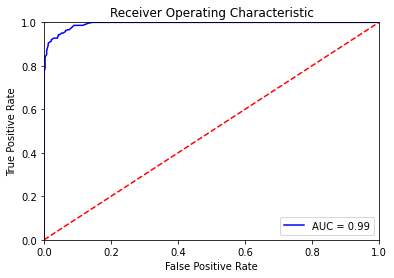

In [24]:
plotAUROC(random_forest_pipe, X_test, y_test)

In [25]:
get_confusion_matrix(y_test, y_pred_test)

,Predicted Not Poisonous,Predicted Poisonous
True Not Poisonous,605,46
True Poisonous,22,627


# Final Output

In [ ]:
random_forest_pipe.fit(X, y)
y_pred_final = random_forest_pipe.predict(X_test_final)

[ColumnTransformer] ...... (1 of 1) Processing cat_pipe, total=   0.0s


In [18]:
(
    mushrooms_test
    .assign(poisonous=y_pred_final)
    [['Id', 'poisonous']]
    .to_csv('submission.csv', index=False)
)